In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import sys
sys.path.append("/Users/hhg/Research/kinematic_lensing/repo/kl_measurement/scripts/")
sys.path.append("/Users/hhg/Research/kinematic_lensing/repo/KLens/")

from generate_TFcube import get_TFcube_pars, get_data_TFcube

Populating the interactive namespace from numpy and matplotlib
dir_tfCube: /Users/hhg/Research/kinematic_lensing/repo/KLens


In [2]:
sys.path.append("/Users/hhg/Research/kinematic_lensing/code/BinnedFit/")

from binnedFit_utilities import *

In [3]:
Gal0 = Galaxy(a=1.5, b=1.0)

sini = Gal0.sini
gamma_p = 0.0
gamma_x = 0.2

A = np.array([[1+gamma_p, gamma_x],[gamma_x, 1-gamma_p]])
A_inv = np.linalg.inv(A)

print('matrix A:',A)
print('matrix A^-1:', A_inv)

expected sini: 0.7607257743127307
matrix A: [[1.  0.2]
 [0.2 1. ]]
matrix A^-1: [[ 1.04166667 -0.20833333]
 [-0.20833333  1.04166667]]


In [4]:
eint_thy = cal_e_int(sini=sini)
eobs_thy = cal_e_obs(e_int=eint_thy, gamma_p=gamma_p)
theta_obs = cal_theta_obs(e_int=eint_thy, gamma_x=gamma_x)

slitAng_major_p = theta_obs
slitAng_minor_p = theta_obs + np.pi/2.

bestfit_e_obs = eobs_thy
print("eobs_thy:", eobs_thy)
print("slitAng_major_p:", slitAng_major_p*180./np.pi)
print("slitAng_minor_p:", slitAng_minor_p*180./np.pi)

def line_pts(theta_deg):
    L = 10.
    thega_rad = theta_deg/180.*np.pi
    xp = L*np.cos(thega_rad)
    yp = L*np.sin(thega_rad)
    
    return [xp, -xp], [yp, -yp]

eobs_thy: 0.38461538461538464
slitAng_major_p: 29.79380534680281
slitAng_minor_p: 119.79380534680281


In [5]:
par_TF, _ = get_TFcube_pars()

par_TF['slitAngles'] = np.array([0.])

par_TF['g1'] = gamma_p
par_TF['g2'] = gamma_x
par_TF['sini'] = sini
par_TF['vcirc'] = 200. 

par_TF['n_knots'] = 25.
par_TF['knot_fraction'] = 0.0
par_TF['throughput'] = 0.29
par_TF['slitWidth'] = 0.05
par_TF['psfFWHM'] = 0.5
par_TF['pixScale'] = 0.1185# 0.1185  # 0.032 

par_TF['redshift'] = 0.2
par_TF['Resolution'] = 6000.
par_TF['nm_per_pixel'] = 0.033 #0.033 # 0.025
par_TF['expTime'] = 3600.0 
par_TF['linelist']['flux'][par_TF['linelist']['species'] == 'Halpha'] = 6.0e-24
par_TF['lambda_min'] = (1 + par_TF['redshift']) * par_TF['linelist']['lambda'][par_TF['linelist']['species'] == 'Halpha'] - 2
par_TF['lambda_max'] = (1 + par_TF['redshift']) * par_TF['linelist']['lambda'][par_TF['linelist']['species'] == 'Halpha'] + 2
par_TF['norm'] = 0.
par_TF['ngrid'] = 256
par_TF['image_size'] = 128

extent =  par_TF['image_size'] * par_TF['pixScale']
grid1d = np.linspace(-extent/2., extent/2., par_TF['ngrid'])
X, Y = np.meshgrid(grid1d, grid1d)
R = np.sqrt(X**2 + Y**2)
THETA = np.angle(X+1j*Y)

In [6]:
def getPhi(theta, pars):
    # This is re-assigning angles in the image plane according to the true inclination of the disk.
    if pars['sini'] == 1 or pars['sini'] == -1:
        phi = np.zeros((pars['ngrid'], pars['ngrid']))
        half_ngrid = int(pars['ngrid']/2)
        phi[:, :half_ngrid] = np.pi
        return phi
    else:
        cosi = np.sqrt(1 - pars['sini']**2)
        phi = np.arctan2(np.sin(theta)/cosi, np.cos(theta))
        return phi

def getR(x, y, pars):
    cosi = np.sqrt(1 - pars['sini']**2)
    y_faceon = y/cosi
    x_faceon = x
    r_faceon = np.sqrt(x_faceon**2 + y_faceon**2)
    return r_faceon

def getXY_0shear(x, y, A_inv):
    x_0shear = x*A_inv[0, 0] + y*A_inv[0, 1]
    y_0shear = x*A_inv[1, 0] + y*A_inv[1, 1]
    return x_0shear, y_0shear 

In [7]:
PHI_fo = getPhi(THETA, pars=par_TF)
R_fo = getR(X, Y, pars=par_TF)

X_0shear, Y_0shear = getXY_0shear(X, Y, A_inv)
THETA_0shear = np.angle(X_0shear+1j*Y_0shear)
R_fo_0shear = getR(X_0shear, Y_0shear, pars=par_TF)
PHI_fo_0shear = getPhi(THETA_0shear, pars=par_TF)

In [8]:
# ===== velocity field =====
V_old   = 2./np.pi * par_TF['vcirc'] * sini * np.arctan(R/par_TF['vscale'])           * np.cos( PHI_fo )
V_Rcorr = 2./np.pi * par_TF['vcirc'] * sini * np.arctan(R_fo/par_TF['vscale'])        * np.cos( PHI_fo )
V_shear = 2./np.pi * par_TF['vcirc'] * sini * np.arctan(R_fo_0shear/par_TF['vscale']) * np.cos( PHI_fo_0shear )

Text(0.5, 1.0, 'g1=0.0    g2=0.2    sini=0.761')

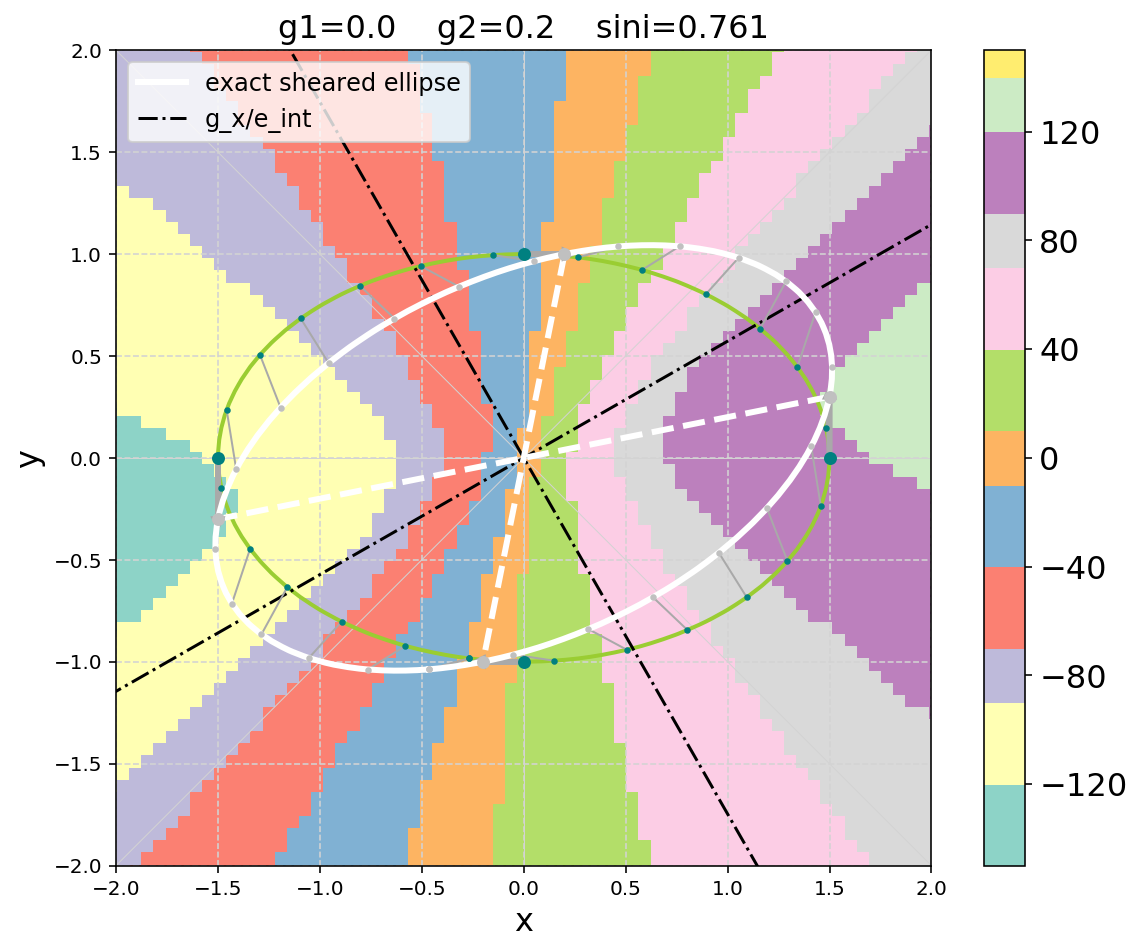

In [9]:
fig, ax = plt.subplots(1,1, figsize=(9.5,7.5))
plt.rc('font',size=16)

CS_gal0 = ax.contour(X, Y, Gal0.eq_ellipse0(X, Y), [0], colors='yellowgreen', linewidths=2.)

# ===== plot pts on the original ellipse =====
pts_gal0 = Gal0.pts_on_ellipse(X, Y, sparsity=7)
ax.scatter(pts_gal0[:,0], pts_gal0[:,1], s=5, color='teal', zorder=15)
ax.scatter(Gal0.tip_pts[:,0], Gal0.tip_pts[:,1], s=30, color='teal', zorder=15)
# ============================================

# ===== plot pts on the sheard ellipse ===== 
pts_gal0_sheard_all = Gal0.pts_on_ellipse(X, Y, sparsity=1, A=A) # get points on the sheard ellipse
ax.plot(pts_gal0_sheard_all[:,0], pts_gal0_sheard_all[:,1], color='white', label='exact sheared ellipse',lw=3, zorder=8)
# ==========================================

# ===== display mapping relationship =====
pts_gal0_sheard = Gal0.pts_on_ellipse(X, Y, sparsity=7, A=A)
ax.scatter(pts_gal0_sheard[:,0], pts_gal0_sheard[:,1], s=5, color='silver', zorder=10)

tip_pts_sheard = (A @ Gal0.tip_pts.T).T        # add shear
ax.scatter(tip_pts_sheard[:,0], tip_pts_sheard[:,1], s=30, color='silver', zorder=10)
    
    # === link mapped (minor) points ===
dx = pts_gal0_sheard[:,0] - pts_gal0[:,0]
dy = pts_gal0_sheard[:,1] - pts_gal0[:,1]
for j in range(len(pts_gal0)):
    #ax.arrow(pts_gal0[j,0], pts_gal0[j,1], dx[j], dy[j], head_width = 0.04, head_length=0.04, fc ='rosybrown', ec ='rosybrown')
    ax.plot([pts_gal0[j,0], pts_gal0_sheard[j,0]], [pts_gal0[j,1], pts_gal0_sheard[j,1]], linewidth=1, color='darkgray', zorder=3)

    # === link mapped (tip) points ===
dx = tip_pts_sheard[:,0] - Gal0.tip_pts[:,0]
dy = tip_pts_sheard[:,1] - Gal0.tip_pts[:,1]
for j in range(len(tip_pts_sheard)):
    ax.arrow(Gal0.tip_pts[j,0], Gal0.tip_pts[j,1], dx[j], dy[j], head_width = 0.03, head_length=0.03, fc ='darkgray', ec ='darkgray', lw=2.8, zorder=3)

# =========================================

# ===== sheared max, min velocity axes =====
pt_left_sheard = tip_pts_sheard[0]
pt_right_sheard = tip_pts_sheard[1]
pt_top_sheard = tip_pts_sheard[2]
pt_bottom_sheard = tip_pts_sheard[3]

ax.plot([pt_left_sheard[0], pt_right_sheard[0]],[pt_left_sheard[1], pt_right_sheard[1]], linewidth=3, ls='--', color='white', zorder=3)
ax.plot([pt_top_sheard[0], pt_bottom_sheard[0]],[pt_top_sheard[1], pt_bottom_sheard[1]], linewidth=3, ls='--', color='white', zorder=3)

# =========================================

# ===== velocity maps =====
levels = MaxNLocator(nbins=30).tick_values(-150., 150.)
#levels = MaxNLocator(nbins=35).tick_values(V_old.min(), V_old.max())
norm = BoundaryNorm(levels, ncolors=plt.cm.Set3.N, clip=True)

#Vmap = ax.pcolormesh(X, Y, V_old, cmap=plt.cm.jet, norm=norm, zorder=-2)
#Vmap = ax.pcolormesh(X, Y, V_Rcorr, cmap=plt.cm.Set3, norm=norm, zorder=-2)
Vmap = ax.pcolormesh(X, Y, V_shear, cmap=plt.cm.Set3, norm=norm, zorder=-2)


# Vdiff = V_Rcorr-V_old
# levels = MaxNLocator(nbins=30).tick_values(-7.,7.)
# norm = BoundaryNorm(levels, ncolors=plt.cm.jet.N, clip=True)
# Vmap = ax.pcolormesh(X, Y, Vdiff, cmap=plt.cm.jet, norm=norm, zorder=-2)

fig.colorbar(Vmap, ax=ax)
# =========================

# ===== plot thy. sheared major axes =====

x_M, y_M = line_pts(theta_deg=29.7938)
ax.plot(x_M, y_M, color = 'k',ls='-.', label='g_x/e_int')

x_m, y_m = line_pts(theta_deg=119.7938)
ax.plot(x_m, y_m, color = 'k',ls='-.')

# =========================# =============

# ===== background corss ===== 
ax.axhline(y=0,color='lightgray',zorder=-1,lw=0.5)
ax.axvline(x=0,color='lightgray',zorder=-1,lw=0.5)
ax.plot([-10, 10], [-10, 10], color = 'lightgray', zorder=-1,lw=0.5)
ax.plot([ 10,-10], [-10, 10], color = 'lightgray', zorder=-1,lw=0.5)
ax.grid(color='lightgray',linestyle='--')
# ============================

ax.legend(loc="upper left",prop={'size':12})

axixlim = 2
ax.set_xlim((-axixlim, axixlim))
ax.set_ylim((-axixlim, axixlim))
ax.set_aspect('equal')

ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)

ax.set_title(f'g1={gamma_p}    g2={gamma_x}    sini={sini:.3f}', fontsize=16)

In [69]:
pt_top_sheard

array([0.2, 1. ])

In [70]:
pt_bottom_sheard

array([-0.2, -1. ])

In [72]:
tan_theta = (pt_bottom_sheard[1]-pt_top_sheard[1])/(pt_bottom_sheard[0]-pt_top_sheard[0])
tan_theta

5.0

In [75]:
theta = np.arctan(tan_theta)
theta/np.pi*180.

78.6900675259798

Text(0.5, 1.0, 'g1=0.0    g2=0.2')

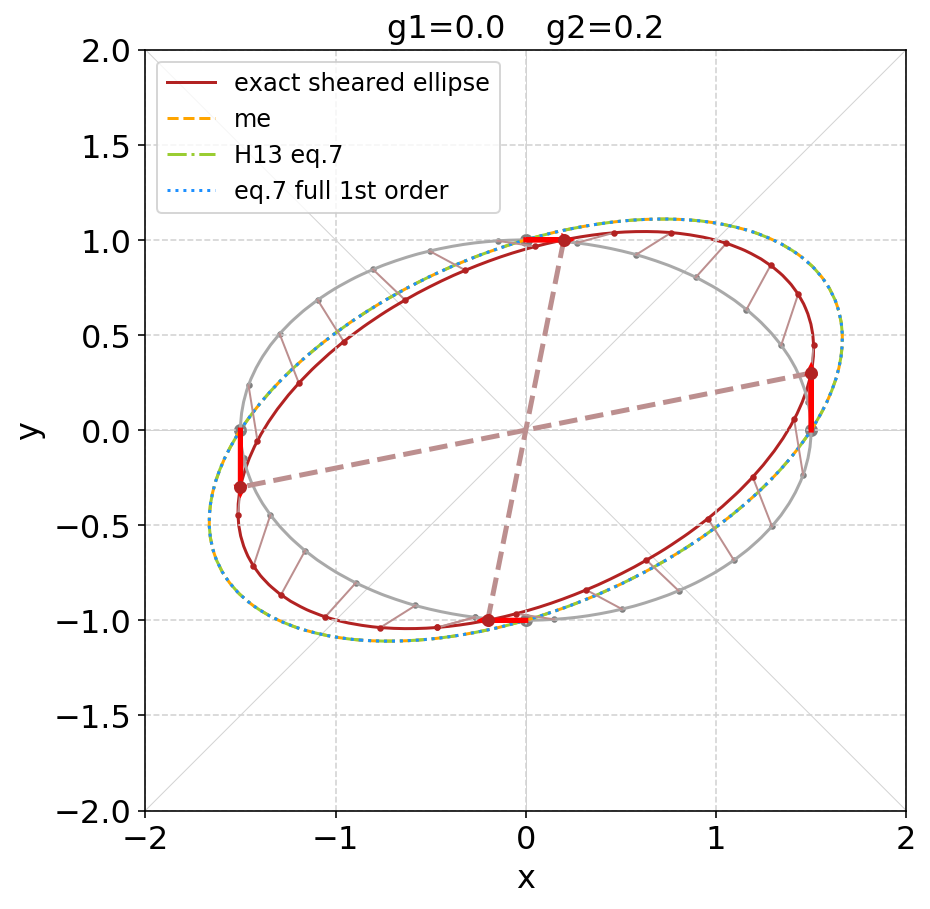

In [9]:
fig, ax = plt.subplots(1,1, figsize=(9,7))
plt.rc('font',size=16)

CS_gal0 = ax.contour(X, Y, Gal0.eq_ellipse0(X, Y), [0], colors='darkgray')

#===== plot ellipse eqs. =====
CS_gal_shear_v1   = ax.contour(X, Y, Gal0.eq_ellipse_sheared_v1(X, Y, gamma_p, gamma_x)  , [0], colors='orange',linestyles='--')
CS_gal_shear_H13  = ax.contour(X, Y, Gal0.eq_ellipse_sheared_H13(X, Y, gamma_p, gamma_x) , [0], colors='yellowgreen',linestyles='-.')
CS_gal_shear_H13p = ax.contour(X, Y, Gal0.eq_ellipse_sheared_H13p(X, Y, gamma_p, gamma_x), [0], colors='dodgerblue',linestyles=':')
   # === legend ===
CS_gal_shear_v1.collections[0].set_label('me')
CS_gal_shear_H13.collections[0].set_label('H13 eq.7')
CS_gal_shear_H13p.collections[0].set_label('eq.7 full 1st order')
#=============================


# ===== plot pts on the original ellipse =====
pts_gal0 = Gal0.pts_on_ellipse(X, Y, sparsity=7)
ax.scatter(pts_gal0[:,0], pts_gal0[:,1], s=5, color='grey')
ax.scatter(Gal0.tip_pts[:,0], Gal0.tip_pts[:,1], s=30, color='grey')
# ============================================


# ===== plot pts on the sheard ellipse ===== 
pts_gal0_sheard_all = Gal0.pts_on_ellipse(X, Y, sparsity=1, A=A) # get points on the sheard ellipse
ax.plot(pts_gal0_sheard_all[:,0], pts_gal0_sheard_all[:,1], color='firebrick', zorder=0, label='exact sheared ellipse')
# ==========================================


# ===== display mapping relationship =====
pts_gal0_sheard = Gal0.pts_on_ellipse(X, Y, sparsity=7, A=A)
ax.scatter(pts_gal0_sheard[:,0], pts_gal0_sheard[:,1], s=5, color='firebrick', zorder=10)

tip_pts_sheard = (A @ Gal0.tip_pts.T).T        # add shear
ax.scatter(tip_pts_sheard[:,0], tip_pts_sheard[:,1], s=30, color='firebrick', zorder=10)
    
    # === link mapped (minor) points ===
dx = pts_gal0_sheard[:,0] - pts_gal0[:,0]
dy = pts_gal0_sheard[:,1] - pts_gal0[:,1]
for j in range(len(pts_gal0)):
    #ax.arrow(pts_gal0[j,0], pts_gal0[j,1], dx[j], dy[j], head_width = 0.04, head_length=0.04, fc ='rosybrown', ec ='rosybrown')
    ax.plot([pts_gal0[j,0], pts_gal0_sheard[j,0]], [pts_gal0[j,1], pts_gal0_sheard[j,1]], linewidth=1, color='rosybrown', zorder=3)

    # === link mapped (tip) points ===
dx = tip_pts_sheard[:,0] - Gal0.tip_pts[:,0]
dy = tip_pts_sheard[:,1] - Gal0.tip_pts[:,1]
for j in range(len(tip_pts_sheard)):
    ax.arrow(Gal0.tip_pts[j,0], Gal0.tip_pts[j,1], dx[j], dy[j], head_width = 0.03, head_length=0.03, fc ='r', ec ='r', lw=2.5, zorder=3)

# =========================================


# ===== sheared max, min velocity axes =====
pt_left_sheard = tip_pts_sheard[0]
pt_right_sheard = tip_pts_sheard[1]
pt_top_sheard = tip_pts_sheard[2]
pt_bottom_sheard = tip_pts_sheard[3]

ax.plot([pt_left_sheard[0], pt_right_sheard[0]],[pt_left_sheard[1], pt_right_sheard[1]], linewidth=2.5, ls='--', color='rosybrown', zorder=3)
ax.plot([pt_top_sheard[0], pt_bottom_sheard[0]],[pt_top_sheard[1], pt_bottom_sheard[1]], linewidth=2.5, ls='--', color='rosybrown', zorder=3)
# =========================================

# ===== background corss ===== 
ax.axhline(y=0,color='lightgray',zorder=-1,lw=0.5)
ax.axvline(x=0,color='lightgray',zorder=-1,lw=0.5)
ax.plot([-10, 10], [-10, 10], color = 'lightgray', zorder=-1,lw=0.5)
ax.plot([ 10,-10], [-10, 10], color = 'lightgray', zorder=-1,lw=0.5)
ax.grid(color='lightgray',linestyle='--')
# ============================

ax.legend(loc="upper left",prop={'size':12})

axixlim = 2
ax.set_xlim((-axixlim, axixlim))
ax.set_ylim((-axixlim, axixlim))
ax.set_aspect('equal')

ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)

ax.set_title(f'g1={gamma_p}    g2={gamma_x}', fontsize=16)

In [10]:
??ax.contour

In [22]:
??cal_theta_obs